# **Klasifikasi Cat & Dog Menggunakan CNN**

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pwd

/content


In [2]:
#Import Library OS/Zipfile
import os
import zipfile

base_url = "/content/gdrive/MyDrive/Dataset"

train_zip = base_url + "/Training.zip"
zip_ref = zipfile.ZipFile(train_zip, 'r')
zip_ref.extractall('/tmp')

val_zip = base_url + "/Validation.zip"
zip_ref = zipfile.ZipFile(val_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
# Folder training untuk class cat
train_Cat_dir = os.path.join('/tmp/Training/Cat')

# Folder training untuk class dog
train_Dog_dir = os.path.join('/tmp/Training/Dog')

# Folder validation untuk class cat
valid_Cat_dir = os.path.join('/tmp/Validation/Cat')

# Folder validation untuk class dog
valid_Dog_dir = os.path.join('/tmp/Validation/Dog')

In [4]:
train_Cat_names = os.listdir(train_Cat_dir)
print(train_Cat_names[:10])

train_Dog_names = os.listdir(train_Dog_dir)
print(train_Dog_names[:10])

validation_Cat_hames = os.listdir(valid_Cat_dir)
print(validation_Cat_hames[:10])

validation_Dog_names = os.listdir(valid_Dog_dir)
print(validation_Dog_names[:10])

['240.png', '243.png', '89.png', '21.png', '155.png', '181.png', '48.png', '216.png', '32.png', '3.png']
['d75.png', 'd46.png', 'd123.png', 'd126.png', 'd141.png', 'd167.png', 'd68.png', 'd76.png', 'd13.png', 'd89.png']
['334.png', '349.png', 't87.png', '287.png', 't79.png', '280.png', '394.png', '299.png', '307.png', 't84.png']
['d315.png', 'd373.png', 'g84.png', 'd287.png', 'd270.png', 'g93.png', 'd262.png', 'd395.png', 'g99.png', 'd268.png']


Mencari informasi berapa total images dari cat dan dog di directory :

In [5]:
print('total training Cat images:', len(os.listdir(train_Cat_dir)))
print('total training Dog images:', len(os.listdir(train_Dog_dir)))
print('total validation Cat images:', len(os.listdir(valid_Cat_dir)))
print('total validation Dog images:', len(os.listdir(valid_Dog_dir)))

total training Cat images: 247
total training Dog images: 247
total validation Cat images: 253
total validation Dog images: 253


In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2 as cv

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 1

Menampilkan 8 batch dari 8 Cat and 8 Cat pictures. Kamu bisa melakukan rerun cell kembali untuk melihat fresh batch setiap waktu:

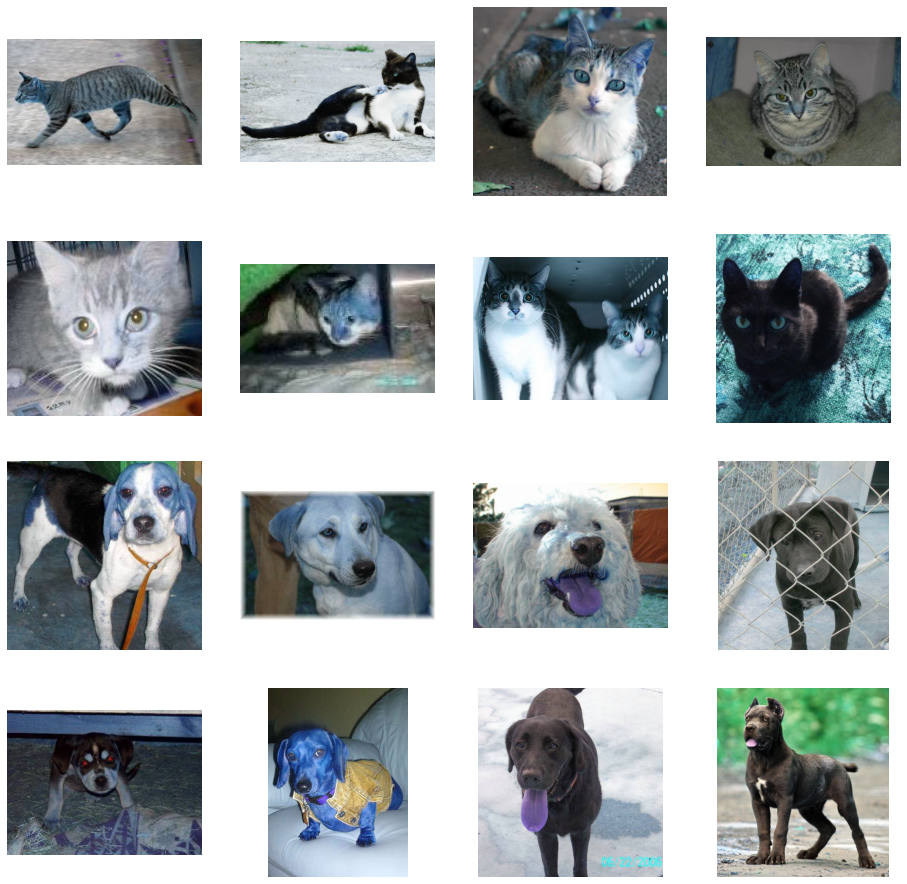

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_Cat_pic = [os.path.join(train_Cat_dir, fname) 
                for fname in train_Cat_names[pic_index-8:pic_index]]
next_Dog_pic = [os.path.join(train_Dog_dir, fname) 
                for fname in train_Dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_Cat_pic + next_Dog_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  im = cv.imread(img_path)
  plt.imshow(im)

plt.show()


#### Data Preprocessing

Menggunakan `keras.preprocessing.image.ImageDataGenerator` class untuk membuat  train and validation dataset dan normalize data. 
Sangat penting untuk melakukan normalize data karena data akan diproses oleh CNN untuk improve performance secara keseluruhan. Disini kita akan menggunakan `rescale` parameter untuk scale our image pixel values dari [0, 255] ke [0,1].

Disetiap generator, kita menentukan source directory dari images, classes, input image size, batch size (seberapa banyak images yang akan diproses), dan class mode.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/Training/',  # This is the source directory for training images
        classes = ['Cat', 'Dog'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/Validation/',  # This is the source directory for training images
        classes = ['Cat', 'Dog'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 494 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


(120, 200, 200, 3)


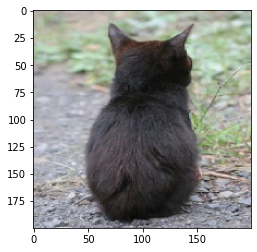

(120, 200, 200, 3)


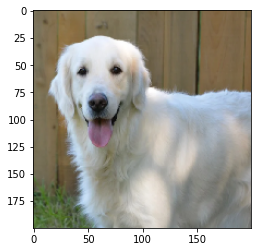

(120, 200, 200, 3)


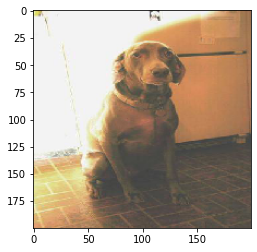

(120, 200, 200, 3)


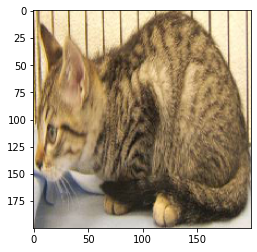

(14, 200, 200, 3)


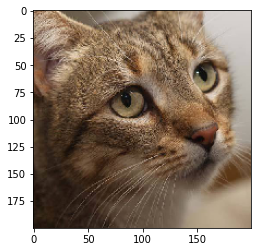

In [9]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()



## Building the Model from Scratch

Memulai menentukan model:

Step 1 import tensorflow.

In [10]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# from scipy import interp
from sklearn.metrics import roc_auc_score

Menambahkan Conv2D layer akan mengoperasikan convolution pada layer tersebut, nilai stride dideskripsikan menggunakan 2 Dimensi meskipun dimensi stride tidak wajib sama misal 3,2 atau 4,5 dll. Pada layer convolution jumlah trainable parameter bukan menjadi jumlah neuron per layer  tapi hanya menunjukkan jumlah channel dan bobot per neuron. Parameter padding digunakan jika kita ingin jumlah neuron per channel sama dengan jumlah pixel citra, parameter 'same' menghasilkan padding yang diperlukan agar jumlah neuron=jumlah pixel. Jumlah neuron pada layer Conv2D tidak dideskripsikan karena sudah dideskripsikan oleh parameter lain, contoh: kombinasi padding='same' dan stride=(2,2) menghasilkan neuron separuh dari jumlah total pixel(ukuran gambar 200X200 3 channel->jumlah total pixel=120000, maka jumlah neuron akan menjadi 60000)
Menambahkan Flatten layer yang akan mem-flatten input image, dimana akan dilanjutkan ke next layer, Dense layer, atau fully-connected layer, dengan 128 hidden units, Flatten layer pada model ini tidak memerlukan input size karena sudah dideskripsikan pada Conv2D layer pertama
Pada tujuan akhirnya adalah untuk  melakukan binary classification, final layer akan menggunakan sigmoid, jadi output dari neural network akan menjadi single scalar antara 0 and 1, dengan melakukan encoding  probability pada image saat ini dengan class 
(class 1 menjadi dog dan class 0 menjadi cat).

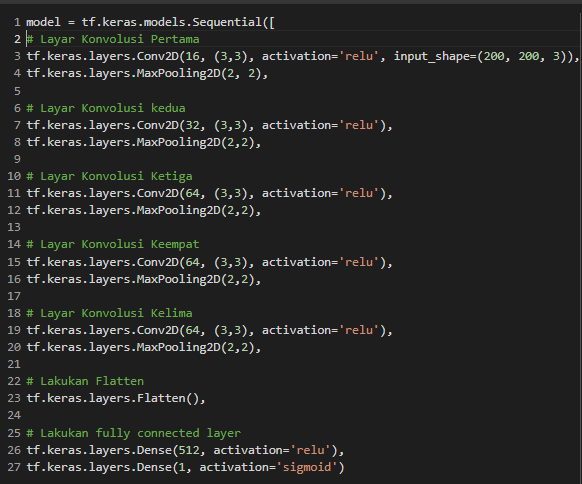

In [14]:
model = tf.keras.models.Sequential([
#First Layer
tf.keras.layers.Conv2D(16, (3, 3),activation='relu', padding = 'same',input_shape = (200, 200, 3)), 
tf.keras.layers.MaxPooling2D(2,2),
#Second Layer                                   
tf.keras.layers.Conv2D(64, (3, 3),activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
#Third Layer                                   
tf.keras.layers.Conv2D(64, (3, 3),activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),

tf.keras.layers.Flatten(), 
tf.keras.layers.Dense(512, activation= 'relu'), 
tf.keras.layers.Dense(1, activation= 'sigmoid')])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 64)        9280      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 64)      

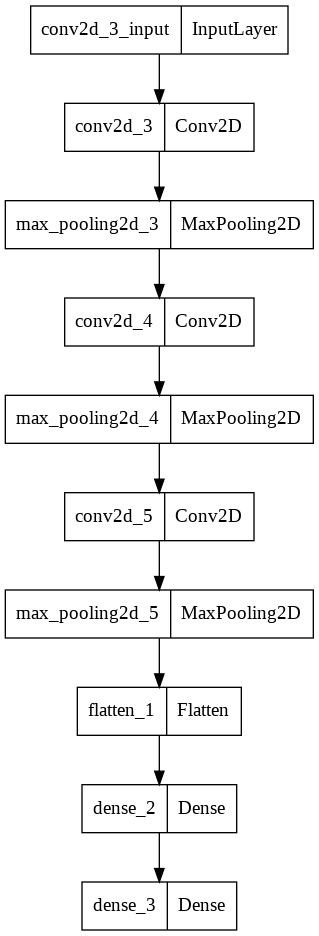

In [16]:
tf.keras.utils.plot_model(model)

Kolom "output shape"  menampilkan transformasi dari setiap dimensi layer sebagai hasil dari convolution and max pooling - convolution akan mengurangi layer size sedikit karena proses padding, dan max pooling membagi 2 output size.

Konfugirasi specifications untuk model training. Kita akan melakukan train model dengan `binary_crossentropy` loss. Kemudian menggunakan `Adam` optimizer. [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) adalah sensible optimization algorithm karena mengautomasi learning-rate tuning untuk kita (alternatifnya, kita bisa menggunakan [RMSProp](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) atau [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad) untuk hasil yang serupa). Kita akan menambahkan accuracy ke `metrics` jadi model akan memonitor accuracy saat melakukan training

In [17]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

### Training
Lakukan training dengan 15 epochs.

Perhatikan steps_per_epoch ditetapkan bersamaan dengan batch_size di ImageDataGenerator jadi steps_per_epoch * batch_size = total # of images.
Sebagai contohnya, untuk training, 5 * 120 = 600, dengan total 999 images.

Perhatikan saat kita melakukan training, validation accuracy tidak pernah melebihi training accuracy, dimana ini adalah sesuatu yang baik. Model tidak akan bekerja lebih baik pada data images yang belum terlihat dibandingkan images yang telah terlihat.

In [18]:
history = model.fit(train_generator,
      steps_per_epoch=5,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
5/5 [==============================] - 28s 6s/step - loss: 1.0311 - accuracy: 0.5405 - val_loss: 0.6266 - val_accuracy: 1.0000
Epoch 2/15
5/5 [==============================] - 26s 5s/step - loss: 0.6952 - accuracy: 0.5223 - val_loss: 0.7530 - val_accuracy: 0.0000e+00
Epoch 3/15
5/5 [==============================] - 27s 5s/step - loss: 0.6927 - accuracy: 0.5142 - val_loss: 0.6051 - val_accuracy: 1.0000
Epoch 4/15
5/5 [==============================] - 26s 5s/step - loss: 0.6950 - accuracy: 0.5121 - val_loss: 0.6885 - val_accuracy: 0.8947
Epoch 5/15
5/5 [==============================] - 26s 5s/step - loss: 0.6880 - accuracy: 0.7004 - val_loss: 0.7132 - val_accuracy: 0.1382
Epoch 6/15
5/5 [==============================] - 26s 5s/step - loss: 0.6779 - accuracy: 0.5789 - val_loss: 0.6581 - val_accuracy: 0.9079
Epoch 7/15
5/5 [==============================] - 26s 5s/step - loss: 0.6547 - accuracy: 0.5789 - val_loss: 0.7787 - val_accuracy: 0.3618
Epoch 8/15
5/5 [==============

## Accuracy, ROC Curve, and AUC

Evaluasi accuracy model:

In [19]:
model.evaluate(validation_generator)

27/27 [==============================] - 8s 296ms/step - loss: 0.8055 - accuracy: 0.6126


[0.8054612278938293, 0.6126482486724854]

Kalkulasi ROC curve dan lakukan plotting.

Lakukan prediction di validation set. Ketika menggunakan generators untuk membuat predictions, Kita matikan shuffle (seperti yang kita lakukan ketika kita membuat validation_generator) dan reset the generator:

In [20]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

27/27 [==============================] - 8s 295ms/step


Untuk membuat ROC curve dan AUC, kita harus menghitung false-positive rate dan  true-positive rate:

In [21]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [22]:
roc_auc = auc(fpr, tpr)

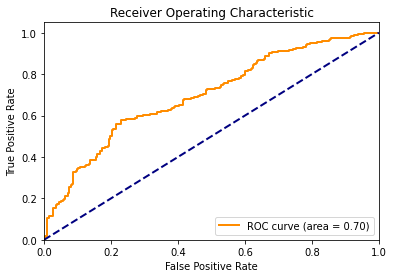

In [24]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save('model_2.h5')

ROC curve probabilitas yang memplot tingkat true-positive rate (TPR) terhadap false-positive rate (FPR). didalam kurva ini, garis diagonal adalah kurva untuk random guessing, seperti coin flipping, jadi ROC curve di atas menunjukkan bahwa model lebih baik daripada kemungkinan melakukan classifying diantara cat dan dog. GOOD!

Demikian pula, AUC (area di bawah kurva), seperti yang ditunjukkan pada legend di atas, mengukur seberapa banyak model untuk mampu membedakan antara dua kelas, cat dan dog. Semakin tinggi AUC, semakin baik model kami dalam klasifikasi.

## Making Predictions
Menggunakan model untuk melakukan predictions! Upload sebuah gambar untuk melihat apakah cat atau dog.

Saving 314611_4-11-2020_13-9-40.jpeg to 314611_4-11-2020_13-9-40 (1).jpeg
[1.]
314611_4-11-2020_13-9-40.jpeg ini adalah Anjing


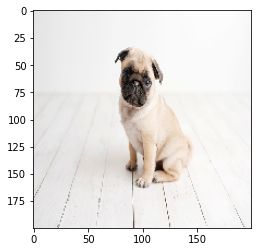

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " ini adalah Kucing")
  else:
    print(fn + " ini adalah Anjing")
 

## Clean Up
Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)